# Amazon Textract Grader Workflow
This notebook is the further processing the output data from Amazon Textract Grader project. And, it makes use of Machine Learning techniques and AWS AI Services to complete the grading task.


For the detail of Amazon Textract Grader, https://1drv.ms/b/s!Ave_D3mUzq1vkkDvMTkXsXNdgi3C?e=GapvRO 


In [1]:
studentsScriptFileName = "Actual Test Scripts (after override).xlsx"
standAnswerFileName = "Actual Test Solution_override.xlsx"

# Prerequisite

Install nodejs and jupyter_bbox_widget extension for studiolab environment. https://docs.aws.amazon.com/sagemaker/latest/dg/studio-lab-use-manage.html
1. New terminal.
2. Run ```cd sagemaker-studiolab-notebooks/ ```
3. Run ```conda activate studiolab```
4. Run ```conda install -y nodejs ```
5. Click on extension icon and search "jupyter_bbox_widget"
6. Click install and rebuild.

Setup new Connda Environment
1. New terminal.
2. Run ```cd sagemaker-studiolab-notebooks/ ```
3. Run ```conda env create -f env_basic.yaml ```
4. Refresh your jupter notebook webpage.
5. Select the Kenel "basic".

You can reference https://thenewstack.io/take-amazon-sagemaker-studio-lab-for-a-spin/ to setup conda environment.

To add new packages
1. Update "env_basic.yaml".
2. Run ```conda env update -f env_basic.yaml ```

Add AWS Academy Learner Lab and remember to renew it every 4 hours!
1. Rename AWSAcademyLeanerLab-template.config to AWSAcademyLeanerLab.config.
2. Copy AWS CLI credentials from AWS Academy Learner Lab.
3. Paste it in AWSAcademyLeanerLab.config.

Clean all cell outputs before commit to GitHub.

```jupyter nbconvert --clear-output --inplace amazon_textract_grader_workflow.ipynb```

In [2]:
import configparser

canCallAWS = False

config = configparser.ConfigParser()
config.read("AWSAcademyLeanerLab.config")
config.sections()
awsAccessKeyId = config["default"]["aws_access_key_id"]
awsSecretAccessKeyId = config["default"]["aws_secret_access_key"]
awsSessionToken = config["default"]["aws_session_token"]
if awsAccessKeyId == "" or awsSecretAccessKeyId == "" or awsSessionToken == "":
    print("Missing AWSAcademyLeanerLab credentials")
else:
    import boto3

    boto3.setup_default_session(
        aws_access_key_id=awsAccessKeyId,
        aws_secret_access_key=awsSecretAccessKeyId,
        aws_session_token=awsSessionToken,
        region_name="us-east-1",
    )
    awsAccount = boto3.client("sts").get_caller_identity().get("Account")
    print("Your AWS Account Number: " + awsAccount)
    canCallAWS = True

config.read("smtp.config")
email = config["default"]["email"]
password = config["default"]["password"]
smtp_server = config["default"]["smtp_server"]
smtp_port = config["default"]["smtp_port"]

Your AWS Account Number: 277438828957


In [3]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as spc
from scipy import stats
import os

In [4]:
df_script = pd.read_excel(
    os.path.join(os.getcwd(), "data", studentsScriptFileName), sheet_name=None
)
df_answer = pd.read_excel(
    os.path.join(os.getcwd(), "data", standAnswerFileName), sheet_name=None
)

/home/studio-lab-user/.conda/envs/basic/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [5]:
df_answer["DocumentValue"].head()
df_answer["DocumentValue"].columns

Index(['Q1', 'Q10', 'Q11', 'Q12', 'Q13', 'Q14-No', 'Q14-Yes', 'Q15-No',
       'Q15-Yes', 'Q16', 'Q17', 'Q18-No', 'Q18-Yes', 'Q19-No', 'Q19-Yes', 'Q2',
       'Q20', 'Q21-No', 'Q21-Yes', 'Q22-No', 'Q22-Yes', 'Q23', 'Q24-No',
       'Q24-Yes', 'Q25', 'Q26', 'Q27', 'Q28', 'Q29', 'Q3', 'Q30-No', 'Q30-Yes',
       'Q31', 'Q32', 'Q33', 'Q34', 'Q35', 'Q4', 'Q45-No', 'Q45-Yes', 'Q46-No',
       'Q46-Yes', 'Q47-No', 'Q47-Yes', 'Q48-No', 'Q48-Yes', 'Q49-No',
       'Q49-Yes', 'Q5', 'Q56', 'Q57-No', 'Q57-Yes', 'Q58', 'Q59',
       'Q6 resource', 'Q60', 'Q62', 'Q65', 'Q66', 'Q67', 'Q68', 'Q69', 'Q7',
       'Q70', 'Q8', 'Q9', 'Q36', 'Q38', 'Q40', 'Q50:', 'Q63'],
      dtype='object')

Columns appear in Standard answer but not in Student script, whihc is missing from Amazon Textract and probably because all students do not answer those question!

In [6]:
df_answer["DocumentValue"].columns.difference(df_script["PageAnswerGeometry"].columns)

Index(['Q29', 'Q56', 'Q58', 'Q59', 'Q6 resource', 'Q60', 'Q62', 'Q69', 'Q7',
       'Q9'],
      dtype='object')

Columns appear in student script but not in Standard answer, and you need to updated the answer excel.

In [7]:
df_script["PageAnswerGeometry"].columns.difference(df_answer["DocumentValue"].columns)

Index(['233', '5.14 SMIB', 'Azure', 'Class', 'Class1', 'IC Q17', 'ID', 'ID1',
       'Name', 'Name 1', 'Name: 1', 'Q2 INto', 'Q2 resore Broup Q3',
       'Q7 system tools Q8', 'Resource Q2 Q3', 'Virtual Machine Q3', 'go',
       'las Q17', 'level', 'tempalary'],
      dtype='object')

Common columns

In [8]:
columns = (
    df_script["PageAnswerGeometry"]
    .columns.intersection(df_answer["DocumentValue"].columns)
    .to_list()
)
columns

['Q1',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14-No',
 'Q14-Yes',
 'Q15-No',
 'Q15-Yes',
 'Q16',
 'Q17',
 'Q18-No',
 'Q18-Yes',
 'Q19-No',
 'Q19-Yes',
 'Q2',
 'Q20',
 'Q21-No',
 'Q21-Yes',
 'Q22-No',
 'Q22-Yes',
 'Q23',
 'Q24-No',
 'Q24-Yes',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q3',
 'Q30-No',
 'Q30-Yes',
 'Q31',
 'Q32',
 'Q33',
 'Q34',
 'Q35',
 'Q36',
 'Q38',
 'Q4',
 'Q40',
 'Q45-No',
 'Q45-Yes',
 'Q46-No',
 'Q46-Yes',
 'Q47-No',
 'Q47-Yes',
 'Q48-No',
 'Q48-Yes',
 'Q49-No',
 'Q49-Yes',
 'Q5',
 'Q50:',
 'Q57-No',
 'Q57-Yes',
 'Q63',
 'Q65',
 'Q66',
 'Q67',
 'Q68',
 'Q70',
 'Q8']

Apppend Student Name and ID columns

In [9]:
columns.insert(0, "Name")
columns.insert(0, "ID")
columns

['ID',
 'Name',
 'Q1',
 'Q10',
 'Q11',
 'Q12',
 'Q13',
 'Q14-No',
 'Q14-Yes',
 'Q15-No',
 'Q15-Yes',
 'Q16',
 'Q17',
 'Q18-No',
 'Q18-Yes',
 'Q19-No',
 'Q19-Yes',
 'Q2',
 'Q20',
 'Q21-No',
 'Q21-Yes',
 'Q22-No',
 'Q22-Yes',
 'Q23',
 'Q24-No',
 'Q24-Yes',
 'Q25',
 'Q26',
 'Q27',
 'Q28',
 'Q3',
 'Q30-No',
 'Q30-Yes',
 'Q31',
 'Q32',
 'Q33',
 'Q34',
 'Q35',
 'Q36',
 'Q38',
 'Q4',
 'Q40',
 'Q45-No',
 'Q45-Yes',
 'Q46-No',
 'Q46-Yes',
 'Q47-No',
 'Q47-Yes',
 'Q48-No',
 'Q48-Yes',
 'Q49-No',
 'Q49-Yes',
 'Q5',
 'Q50:',
 'Q57-No',
 'Q57-Yes',
 'Q63',
 'Q65',
 'Q66',
 'Q67',
 'Q68',
 'Q70',
 'Q8']

Remove columns do not show in answer

In [10]:
for key in df_answer.keys():
    df_script[key] = df_script[key][columns]
df_answer.keys()

dict_keys(['DocumentValue', 'DocumentConfidence', 'DocumentAnswerSimilarity', 'DocumentAnswerGeometry', 'DocumentAnswerImage', 'PageValue', 'PageConfidence', 'PageAnswerSimilarity', 'PageAnswerGeometry', 'PageAnswerImage'])

# Preprocessing boundbox with margin.

In [11]:
import os
from urllib.parse import urlparse
import urllib.request
from pathlib import Path
import urllib.request


path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))
path.mkdir(parents=True, exist_ok=True)
images = {}
for rowIndex, row in df_script["DocumentAnswerImage"].iterrows():  # iterate over rows
    for columnIndex, value in row.items():
        if not pd.isna(value) and value not in images:
            url = urlparse(value)
            fileName = os.path.basename(url.path)
            fileName = os.path.join("output", "grading_form", "images", fileName)
            if not os.path.isfile(fileName):
                urllib.request.urlretrieve(value, fileName)
            images[value] = fileName

In [12]:
from PIL import Image

dir_path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))


def mapper(x):
    if pd.isna(x) or x is None:
        return None
    j = json.loads(x)
    if j is None:
        return None
    if "BoundingBox" in j:
        if "page" in j:
            boundingBox = j["BoundingBox"]
            path = Path(os.path.join(dir_path, "p-" + str(j["page"]) + ".png"))
            with Image.open(path) as im:
                # The crop method from the Image module takes four coordinates as input.
                # The right can also be represented as (left+width)
                # and lower can be represented as (upper+height).
                pageWidth, pageHeight = im.size
                boundingBox["page"] = j["page"] + 1
                width, height = im.size

                margin = boundingBox["Height"] * 0.05
                leftMargin = margin + 50
                (left, top, width, height) = (
                    max(pageWidth * boundingBox["Left"] - leftMargin, 0),
                    max(pageHeight * boundingBox["Top"] - margin, 0),
                    min(
                        pageWidth * boundingBox["Width"] + leftMargin + margin,
                        pageWidth,
                    ),
                    min(pageHeight * boundingBox["Height"] + 2 * margin, pageHeight),
                )
                return {
                    "left": left,
                    "top": top,
                    "height": height,
                    "width": width,
                    "page": j["page"],
                }
        try:
            return json.loads(j)["BoundingBox"]
        except:
            print(type(j))


df_script["DocumentBoundingBox"] = df_script["DocumentAnswerGeometry"].applymap(mapper)
df_answer["DocumentBoundingBox"] = df_answer["DocumentAnswerGeometry"].applymap(mapper)

# Preparation for the imputation of missing page

In [13]:
def mapper(x):
    if pd.isna(x) or x is None:
        return 0
    else:
        return 1


df_script["PageAnswer"] = df_script["PageAnswerGeometry"].applymap(mapper)
df_script["PageAnswer"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,0,0,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
1,1,1,0,0,0,0,0,0,0,0,...,1,1,1,0,0,1,1,0,1,0
2,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,1,1,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


Create correlation matrix and apply clustering.

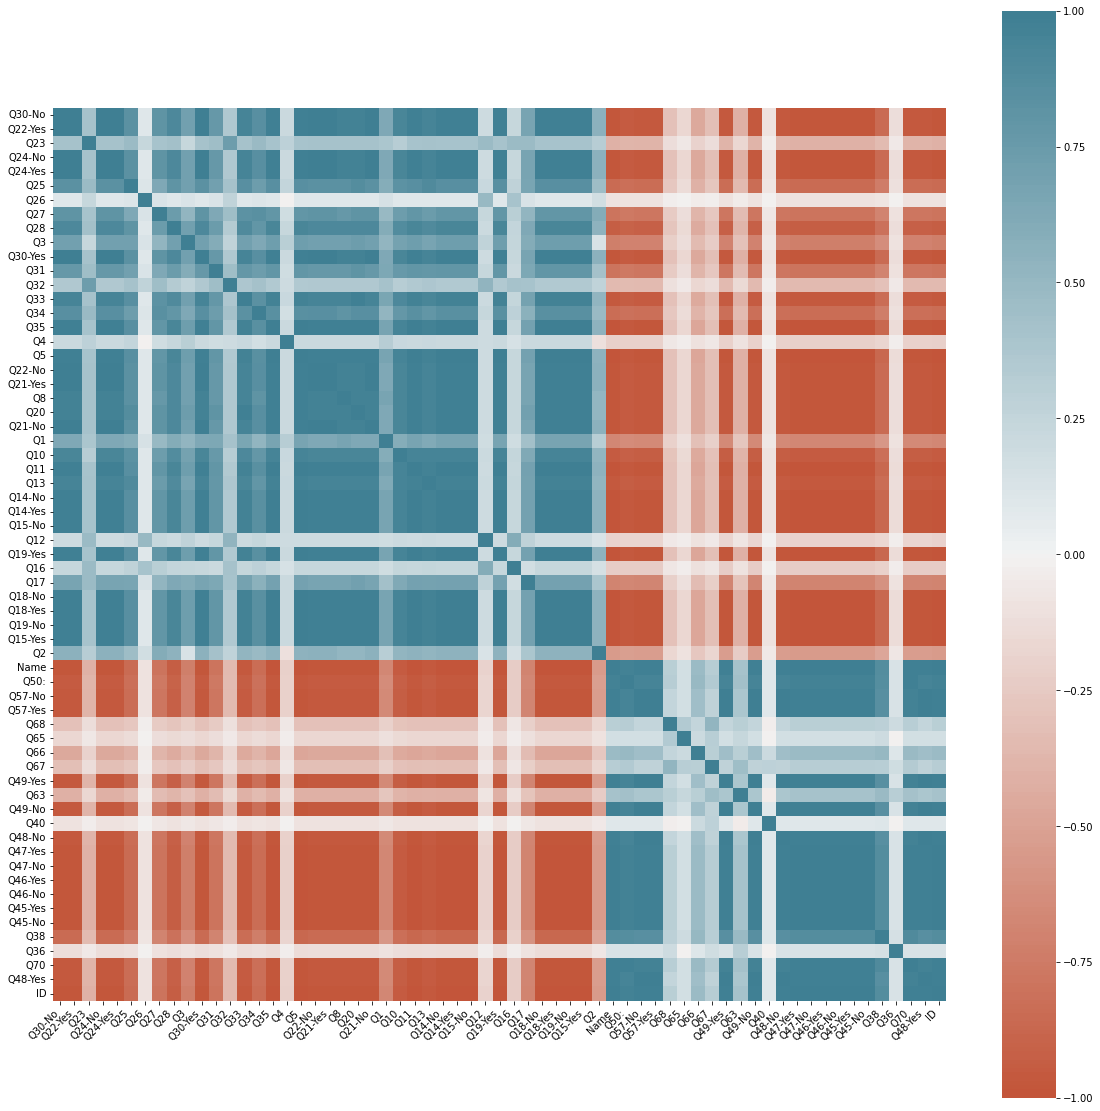

In [14]:
import scipy
import scipy.cluster.hierarchy as sch


def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly
    correlated variables are next to eachother

    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix

    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method="complete")
    cluster_distance_threshold = pairwise_distances.max() / 2
    idx_to_cluster_array = sch.fcluster(
        linkage, cluster_distance_threshold, criterion="distance"
    )
    idx = np.argsort(idx_to_cluster_array)

    if not inplace:
        corr_array = corr_array.copy()

    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]


corr = df_script["PageAnswer"].corr(method="pearson")
corr = cluster_corr(corr)
fig, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(
    corr,
    vmin=-1,
    vmax=1,
    center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right");

A Page contains a set of question and it is a group.

In [15]:
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method="complete")
idx = spc.fcluster(linkage, 0.5 * pdist.max(), "distance")

grouping = pd.DataFrame(data={"question": corr.columns, "group": idx})
grouping

,question,group
0,Q30-No,1
1,Q22-Yes,1
2,Q23,1
3,Q24-No,1
4,Q24-Yes,1
...,...,...
58,Q38,2
59,Q36,2
60,Q70,2
61,Q48-Yes,2


In [16]:
question_group = (
    grouping.groupby("group")["question"].apply(list).reset_index(name="questions")
)
question_group

,group,questions
0,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q..."
1,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q..."


Create ignore flag if the average of correlation is less than 0.5. Because Amazon Textract may capture some noise questions and it will become a group, the noise group correlation is very low.

In [17]:
def get_subgroup_average(questions, corr):
    subdf = corr[questions]
    return subdf[subdf.index.isin(questions)].mean().mean()


question_group["mean"] = question_group["questions"].apply(
    lambda x: get_subgroup_average(x, corr)
)
question_group["ignore"] = question_group["mean"] < 0.5
question_group

,group,questions,mean,ignore
0,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
1,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False


In [18]:
question_mapping = pd.merge(grouping, question_group, how="inner", on="group").rename(
    columns={"questions": "question_set"}
)
question_mapping = question_mapping.set_index("question")
question_mapping

,group,question_set,mean,ignore
question,,,,
Q30-No,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q22-Yes,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q23,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q24-No,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
Q24-Yes,1,"[Q30-No, Q22-Yes, Q23, Q24-No, Q24-Yes, Q25, Q...",0.695542,False
...,...,...,...,...
Q38,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False
Q36,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False
Q70,2,"[Name, Q50:, Q57-No, Q57-Yes, Q68, Q65, Q66, Q...",0.625797,False


By checking question_set, we can impute the missing page number by checking the page in the same set.

# Preparation for the imputation the missing bounding box

Exclude the ignore columns and calculates the ratio of missing value for each question.

In [19]:
columns = question_mapping[question_mapping["ignore"] == False].index
df_script["DocumentBoundingBoxFiltered"] = df_script["DocumentBoundingBox"][columns]
df_script["DocumentBoundingBoxFiltered"].isna().mean().round(4) * 100

Q30-No      1.75
Q22-Yes     1.75
Q23        71.93
Q24-No      1.75
Q24-Yes     1.75
           ...  
Q38        14.04
Q36        96.49
Q70         1.75
Q48-Yes     1.75
ID          0.00
Length: 63, dtype: float64

In [20]:
def get_trim_mean(box, field):
    return stats.trim_mean(list(map(lambda x: x[field], box)), 0.05)


def trimed_mean_bound_box(boxes):
    box = list(filter(lambda box: box is not None, boxes))
    height = get_trim_mean(box, "height")
    left = get_trim_mean(box, "left")
    top = get_trim_mean(box, "top")
    width = get_trim_mean(box, "width")

    return {"height": height, "left": left, "top": top, "width": width}


trimedMeanBoundBoxes = df_script["DocumentBoundingBoxFiltered"].agg(
    trimed_mean_bound_box, axis=0
)
frame = {"boundingBox": trimedMeanBoundBoxes}
estimatedBoundBoxes = pd.DataFrame(frame)
estimatedBoundBoxes.head()

,boundingBox
Q30-No,"{'height': 102.4484228174184, 'left': 3508.050..."
Q22-Yes,"{'height': 100.90692043213821, 'left': 2988.05..."
Q23,"{'height': 276.3572833928978, 'left': 669.3747..."
Q24-No,"{'height': 102.3609463311105, 'left': 3509.589..."
Q24-Yes,"{'height': 101.48595044755808, 'left': 2987.00..."


# Imputation for the missing Bounding box

In [21]:
df_script["DocumentBoundingBoxImpute"] = df_script["DocumentBoundingBox"].copy()

In [22]:
from statistics import mode


def impute_page_and_boundbox(df, row_number, row):
    for key, cell in row.items():
        if cell is None:
            estimatedBoundBox = estimatedBoundBoxes.loc[[key]]["boundingBox"][0]
            questionSet = question_mapping.loc[[key]]["question_set"][0]
            page = mode(
                map(
                    lambda x: x["page"],
                    filter(lambda x: x is not None, map(lambda q: row[q], questionSet)),
                )
            )
            estimatedBoundBox = {
                "left": estimatedBoundBox["left"],
                "top": estimatedBoundBox["top"],
                "height": estimatedBoundBox["height"],
                "width": estimatedBoundBox["width"],
                "page": page,
            }
            df.at[row_number, key] = estimatedBoundBox


for i, j in df_script["DocumentBoundingBox"].iterrows():
    impute_page_and_boundbox(df_script["DocumentBoundingBoxImpute"], i, j)
df_script["DocumentBoundingBoxImpute"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,"{'left': 823.9027038900182, 'top': 960.2456718...","{'left': 893.0692315155641, 'top': 589.0973582...","{'left': 444.6220102198422, 'top': 1078.070501...","{'left': 1482.4444069264457, 'top': 2538.08218...","{'left': 3487.4613205963747, 'top': 2542.46065...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2324.907082133554, 'top': 2905.207050...","{'left': 1259.0419328053947, 'top': 5630.26112...","{'left': 734.1133736902848, 'top': 5628.660752...","{'left': 1257.217829889944, 'top': 5783.833003...",...,"{'left': 3338.6502259938047, 'top': 2690.48311...","{'left': 3573.200520595303, 'top': 6036.137656...","{'left': 3053.2483123840298, 'top': 6030.19859...","{'left': 3546.450780797684, 'top': 4088.472427...","{'left': 2096.6294662560335, 'top': 4470.26584...","{'left': 3550.2638235950844, 'top': 4463.69445...","{'left': 627.4503261795268, 'top': 4825.427331...","{'left': 2084.558112325026, 'top': 4875.328597...","{'left': 565.5899226335808, 'top': 5171.420025...","{'left': 2232.127945062332, 'top': 2174.764624..."
1,"{'left': 684.895612794999, 'top': 948.03695004...","{'left': 770.6556259077042, 'top': 555.5667571...","{'left': 489.46929912663944, 'top': 1088.36926...","{'left': 1493.9150880951433, 'top': 2530.95277...","{'left': 3500.808199974522, 'top': 2537.298319...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2324.9402597147973, 'top': 2896.47468...","{'left': 1275.9714347300119, 'top': 5630.34351...","{'left': 750.0905675122515, 'top': 5630.111074...","{'left': 1272.4719558634329, 'top': 5784.56591...",...,"{'left': 3349.0849856628106, 'top': 2663.52194...","{'left': 3560.4984368418345, 'top': 6034.99847...","{'left': 3044.3368995432743, 'top': 6030.93693...","{'left': 3632.2879639903085, 'top': 4170.73680...","{'left': 2060.508864280209, 'top': 4468.392118...","{'left': 3599.5457994710655, 'top': 4478.23316...","{'left': 605.0846594220027, 'top': 4869.118226...","{'left': 2059.218998424802, 'top': 4905.986548...","{'left': 654.0838392861187, 'top': 5182.513298...","{'left': 2239.2170795969664, 'top': 2132.70846..."
2,"{'left': 618.7491756749339, 'top': 954.8694077...","{'left': 726.8871150016785, 'top': 580.7760912...","{'left': 489.46929912663944, 'top': 1088.36926...","{'left': 1469.2194587824865, 'top': 2525.51803...","{'left': 3479.0450052866713, 'top': 2519.45561...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2347.1398888463154, 'top': 2906.24953...","{'left': 1250.1414197458885, 'top': 5612.25539...","{'left': 725.27060888852, 'top': 5614.16388271...","{'left': 1249.910087740561, 'top': 5770.183128...",...,"{'left': 3246.7672354787587, 'top': 2615.28776...","{'left': 3560.9734715576283, 'top': 6022.45306...","{'left': 3041.79733042093, 'top': 6021.0312229...","{'left': 3527.701726801507, 'top': 4070.327188...","{'left': 2096.6294662560335, 'top': 4470.26584...","{'left': 3532.690424905345, 'top': 4447.681217...","{'left': 589.0851177968085, 'top': 4873.885247...","{'left': 2120.015958631877, 'top': 4860.890892...","{'left': 558.885252331011, 'top': 5149.4463307...","{'left': 2214.2842764491215, 'top': 2127.96807..."
3,"{'left': 617.856411109399, 'top': 988.23378757...","{'left': 709.1612284813076, 'top': 610.0030448...","{'left': 449.13419540561733, 'top': 1085.37182...","{'left': 1479.1275802800433, 'top': 2534.93205...","{'left': 3504.729877394624, 'top': 2549.412671...","{'left': 513.5366480177269, 'top': 2888.436013...","{'left': 2330.7477844782175, 'top': 2923.96795...","{'left': 1276.5413598805667, 'top': 5636.08726...","{'left': 748.9032446485013, 'top': 5639.658433...","{'left': 1275.0109557256103, 'top': 5790.47937...",...,"{'left': 3386.939660468511, 'top': 2713.049635...","{'left': 3560.5184553069994, 'top': 6031.17850...","{'left': 3036.8223247528076, 'top': 6030.96575...","{'left': 3540.630915618874, 'top': 4082.373377...","{'left': 2096.629466256033

# Imputation Image path

In [23]:
df_script["DocumentAnswerImageLocal"] = df_script["DocumentAnswerImage"]
df_script["DocumentAnswerImageLocal"] = df_script["DocumentAnswerImageLocal"].applymap(
    lambda x: images[x], na_action="ignore"
)

df_script["DocumentAnswerImageLocal"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,NaN,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,...,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,NaN,NaN,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,NaN,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png
1,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,NaN,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,NaN,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,...,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png
2,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,NaN,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,NaN,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,...,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,NaN,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png
3,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,NaN,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,...,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,NaN,NaN,NaN,NaN,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png
4,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,NaN,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,NaN,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,...,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,NaN,NaN,NaN,NaN,NaN,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png


In [24]:
import math

path = Path(os.path.join(os.getcwd(), "output", "grading_form", "images"))


def impute_image_path(df, row_number, row):
    for key, cell in row.items():
        if cell is None:
            questionSet = question_mapping.loc[[key]]["question_set"][0]
            page = mode(
                map(
                    lambda x: x["page"],
                    filter(lambda x: x is not None, map(lambda q: row[q], questionSet)),
                )
            )
            df.at[row_number, key] = os.path.join(
                "output", "grading_form", "images", "p-" + str(page) + ".png"
            )


for i, j in df_script["DocumentBoundingBox"].iterrows():
    impute_image_path(df_script["DocumentAnswerImageLocal"], i, j)
df_script["DocumentAnswerImageLocal"].head()

,ID,Name,Q1,Q10,Q11,Q12,Q13,Q14-No,Q14-Yes,Q15-No,...,Q50:,Q57-No,Q57-Yes,Q63,Q65,Q66,Q67,Q68,Q70,Q8
0,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,output/grading_form/images/p-1.png,...,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-2.png,output/grading_form/images/p-1.png
1,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,output/grading_form/images/p-3.png,...,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-4.png,output/grading_form/images/p-3.png
2,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,output/grading_form/images/p-5.png,...,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-6.png,output/grading_form/images/p-5.png
3,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,output/grading_form/images/p-7.png,...,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-8.png,output/grading_form/images/p-7.png
4,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,output/grading_form/images/p-9.png,...,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-10.png,output/grading_form/images/p-9.png


# Preprocessing Choice style questions

In [25]:
estimatedBoundBoxesOptions = estimatedBoundBoxes[
    estimatedBoundBoxes.index.str.endswith("-Yes")
    | estimatedBoundBoxes.index.str.endswith("-No")
    | estimatedBoundBoxes.index.str.endswith("-A")
    | estimatedBoundBoxes.index.str.endswith("-B")
    | estimatedBoundBoxes.index.str.endswith("-C")
    | estimatedBoundBoxes.index.str.endswith("-D")
    | estimatedBoundBoxes.index.str.endswith("-E")
].copy()
estimatedBoundBoxesOptions["question"] = estimatedBoundBoxesOptions.index
estimatedBoundBoxesOptions[["question", "option"]] = estimatedBoundBoxesOptions[
    "question"
].str.split("-", 1, expand=True)
estimatedBoundBoxesOptions.head()

,boundingBox,question,option
Q30-No,"{'height': 102.4484228174184, 'left': 3508.050...",Q30,No
Q22-Yes,"{'height': 100.90692043213821, 'left': 2988.05...",Q22,Yes
Q24-No,"{'height': 102.3609463311105, 'left': 3509.589...",Q24,No
Q24-Yes,"{'height': 101.48595044755808, 'left': 2987.00...",Q24,Yes
Q30-Yes,"{'height': 102.40561179672908, 'left': 2985.78...",Q30,Yes


In [26]:
from shapely import geometry
from functools import reduce


def to_polygon(boundingbox):
    p1 = geometry.Point(boundingbox["left"], boundingbox["top"])
    p2 = geometry.Point(boundingbox["left"] + boundingbox["width"], boundingbox["top"])
    p3 = geometry.Point(boundingbox["left"], boundingbox["top"] + boundingbox["height"])
    p4 = geometry.Point(
        boundingbox["left"] + boundingbox["width"],
        boundingbox["top"] + boundingbox["height"],
    )
    pointList = [p1, p2, p3, p4, p1]
    return geometry.Polygon(pointList)


def to_combined_boundingbox(boundingboxes):
    combined = reduce(
        lambda x, y: x.union(y), map(lambda b: to_polygon(b), boundingboxes)
    )
    x_min = combined.bounds[0]
    y_min = combined.bounds[1]
    x_max = combined.bounds[2]
    y_max = combined.bounds[3]

    boundingbox = {
        "left": x_min,
        "top": y_min,
        "width": x_max - x_min,
        "height": y_max - y_min,
    }
    return boundingbox


questionOptions = estimatedBoundBoxesOptions["question"].to_list()
groupedOptions = estimatedBoundBoxesOptions.groupby(["question"]).apply(dict).to_dict()

combined_boundingbox = dict(
    map(
        lambda q: (q, to_combined_boundingbox(groupedOptions[q]["boundingBox"])),
        groupedOptions,
    )
)

In [27]:
import math

estimatedOptions = pd.DataFrame(
    combined_boundingbox.items(), columns=["question", "boundingBox"]
).set_index("question")
questionToAnswer = df_answer["DocumentValue"].iloc[0].to_dict()
for key, value in questionToAnswer.items():
    # do something with value
    questionToAnswer[key] = value if type(value) is str else ""

choices = ["Yes", "No", "A", "B", "C", "D", "E"]


def get_answer(row):
    queston = row.name
    return set(
        filter(
            lambda x: x != "",
            map(
                lambda x: x
                if queston + "-" + x in questionToAnswer
                and questionToAnswer[queston + "-" + x] == "X"
                else "",
                choices,
            ),
        )
    )


def get_choices(row):
    queston = row.name
    return list(
        filter(
            lambda x: x != "",
            map(
                lambda x: queston + "-" + x
                if queston + "-" + x in questionToAnswer
                else "",
                choices,
            ),
        )
    )


estimatedOptions["answers"] = estimatedOptions.apply(get_answer, axis=1)
estimatedOptions["choices"] = estimatedOptions.apply(get_choices, axis=1)
estimatedOptions

,boundingBox,answers,choices
question,,,
Q14,"{'left': 747.343038871372, 'top': 5622.0426138...",{No},"[Q14-Yes, Q14-No]"
Q15,"{'left': 745.1395789779767, 'top': 5778.346653...",{Yes},"[Q15-Yes, Q15-No]"
Q18,"{'left': 743.7858445982413, 'top': 5933.787396...",{No},"[Q18-Yes, Q18-No]"
Q19,"{'left': 741.4292268433213, 'top': 6089.049383...",{Yes},"[Q19-Yes, Q19-No]"
Q21,"{'left': 2989.785737098847, 'top': 5620.365251...",{No},"[Q21-Yes, Q21-No]"
Q22,"{'left': 2988.052844447189, 'top': 5775.647148...",{Yes},"[Q22-Yes, Q22-No]"
Q24,"{'left': 2987.0048408757552, 'top': 5931.49719...",{No},"[Q24-Yes, Q24-No]"
Q30,"{'left': 2985.7808490820294, 'top': 6087.65460...",{No},"[Q30-Yes, Q30-No]"
Q45,"{'left': 812.6859405272254, 'top': 5691.206684...",{No},"[Q45-Yes, Q45-No]"


In [28]:
questionToAnswer

{'Q1': 'account',
 'Q10': 'security principal',
 'Q11': 'assignment',
 'Q12': 'role definition',
 'Q13': 'grant access to others',
 'Q14-No': 'X',
 'Q14-Yes': '',
 'Q15-No': '',
 'Q15-Yes': 'X',
 'Q16': 'ARM',
 'Q17': 'deny all',
 'Q18-No': 'X',
 'Q18-Yes': '',
 'Q19-No': '',
 'Q19-Yes': 'X',
 'Q2': 'Azure AD account',
 'Q20': 'application rules',
 'Q21-No': 'X',
 'Q21-Yes': '',
 'Q22-No': '',
 'Q22-Yes': 'X',
 'Q23': 'services Endpoint',
 'Q24-No': 'X',
 'Q24-Yes': '',
 'Q25': 'health Probes',
 'Q26': 'RA-GZRS',
 'Q27': 'page blobs',
 'Q28': 'SAS',
 'Q29': 'Azure Files',
 'Q3': 'tenant',
 'Q30-No': 'X',
 'Q30-Yes': '',
 'Q31': 'autoscale',
 'Q32': 'desired state configuration',
 'Q33': 'deployment Slots',
 'Q34': 'load balancer',
 'Q35': 'Azure site recovery',
 'Q4': 'subscription',
 'Q45-No': 'X',
 'Q45-Yes': '',
 'Q46-No': 'X',
 'Q46-Yes': '',
 'Q47-No': '',
 'Q47-Yes': 'X',
 'Q48-No': '',
 'Q48-Yes': 'X',
 'Q49-No': 'X',
 'Q49-Yes': '',
 'Q5': 'regions are paired',
 'Q56': 'MFA',
 

# Review estimated bounding box

If Amazon Textract cannot detect the questions but it rarely happens as it needs to miss in all student scripts, then you can define it here.

Some cases are because all students do not answer that question it will not be able to detected by Amazon Textract.

page 1


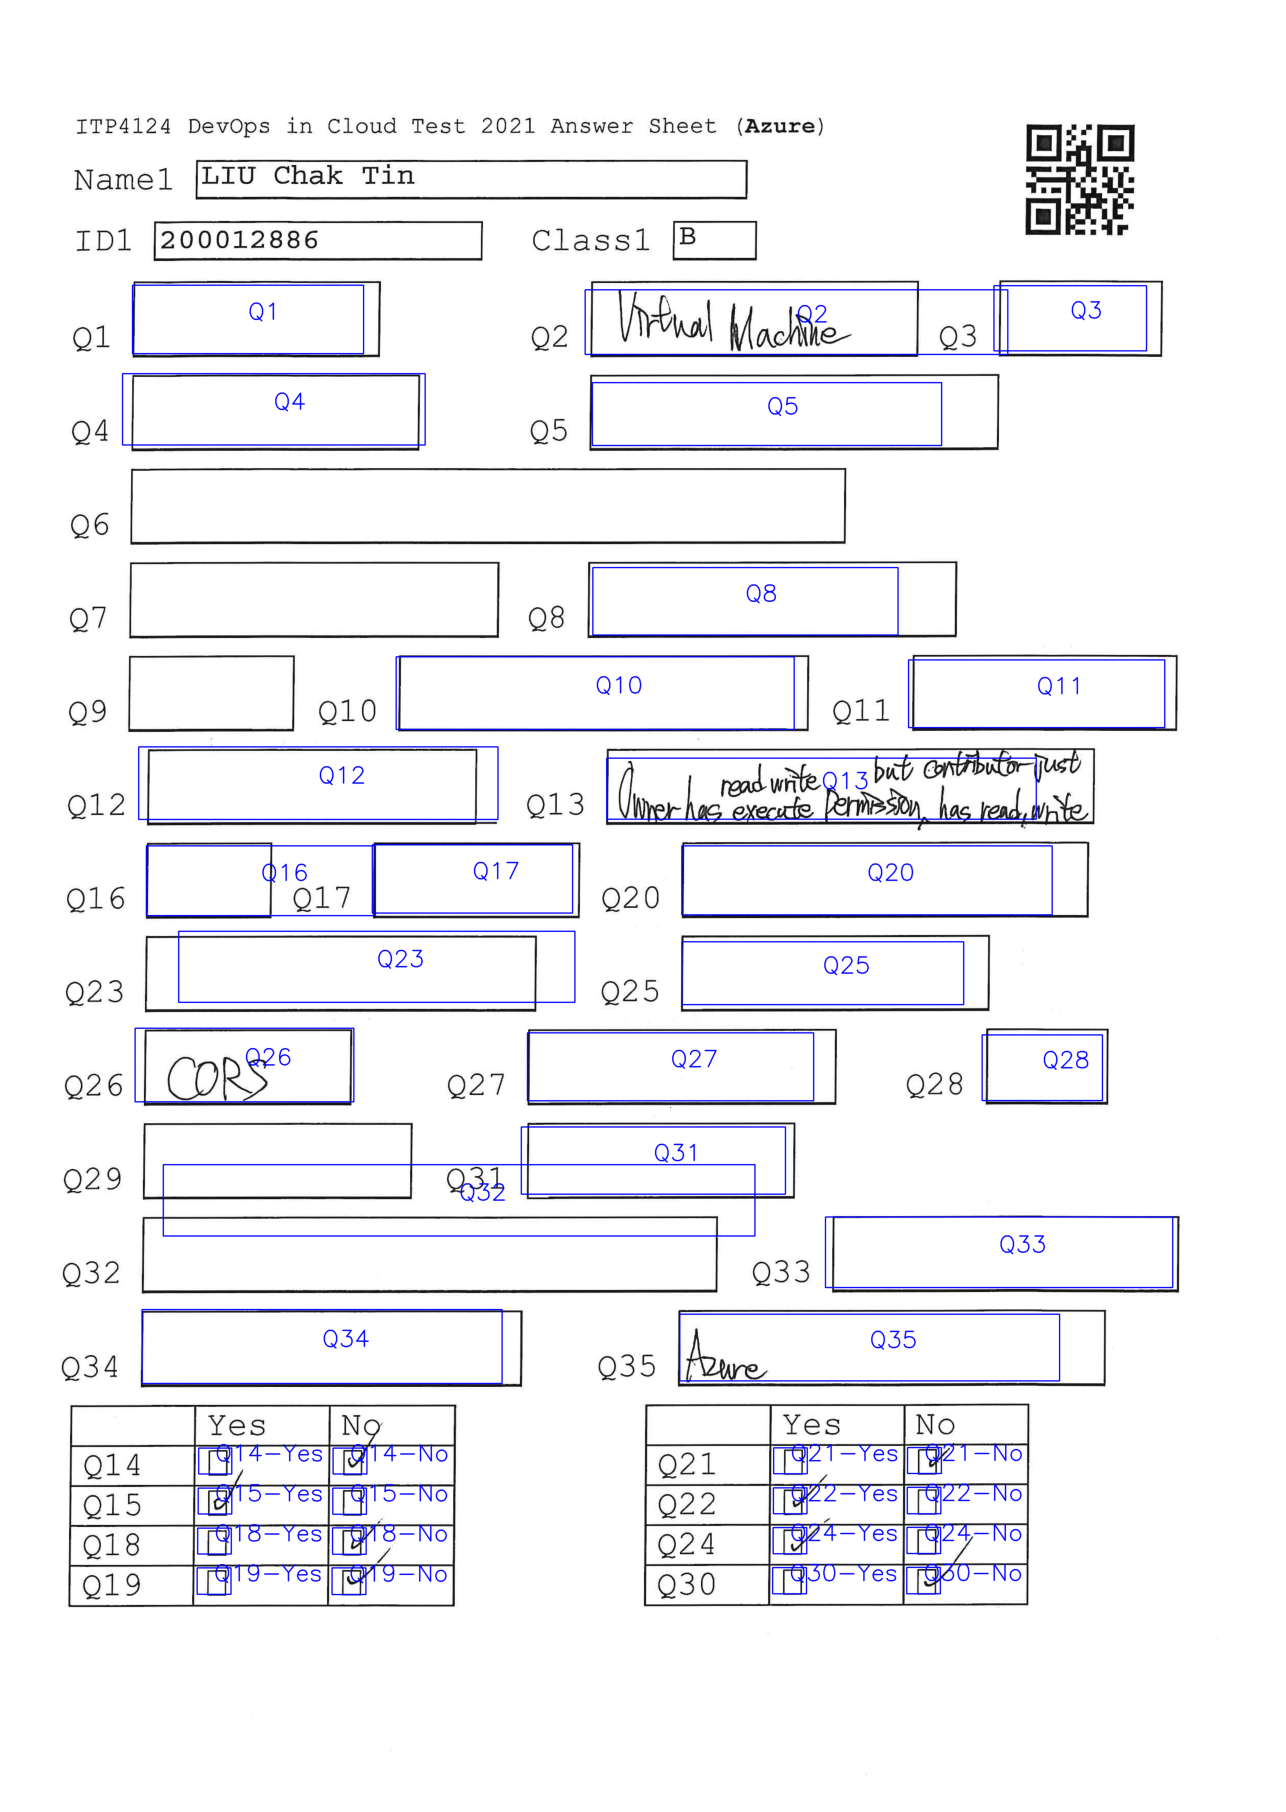

page 2


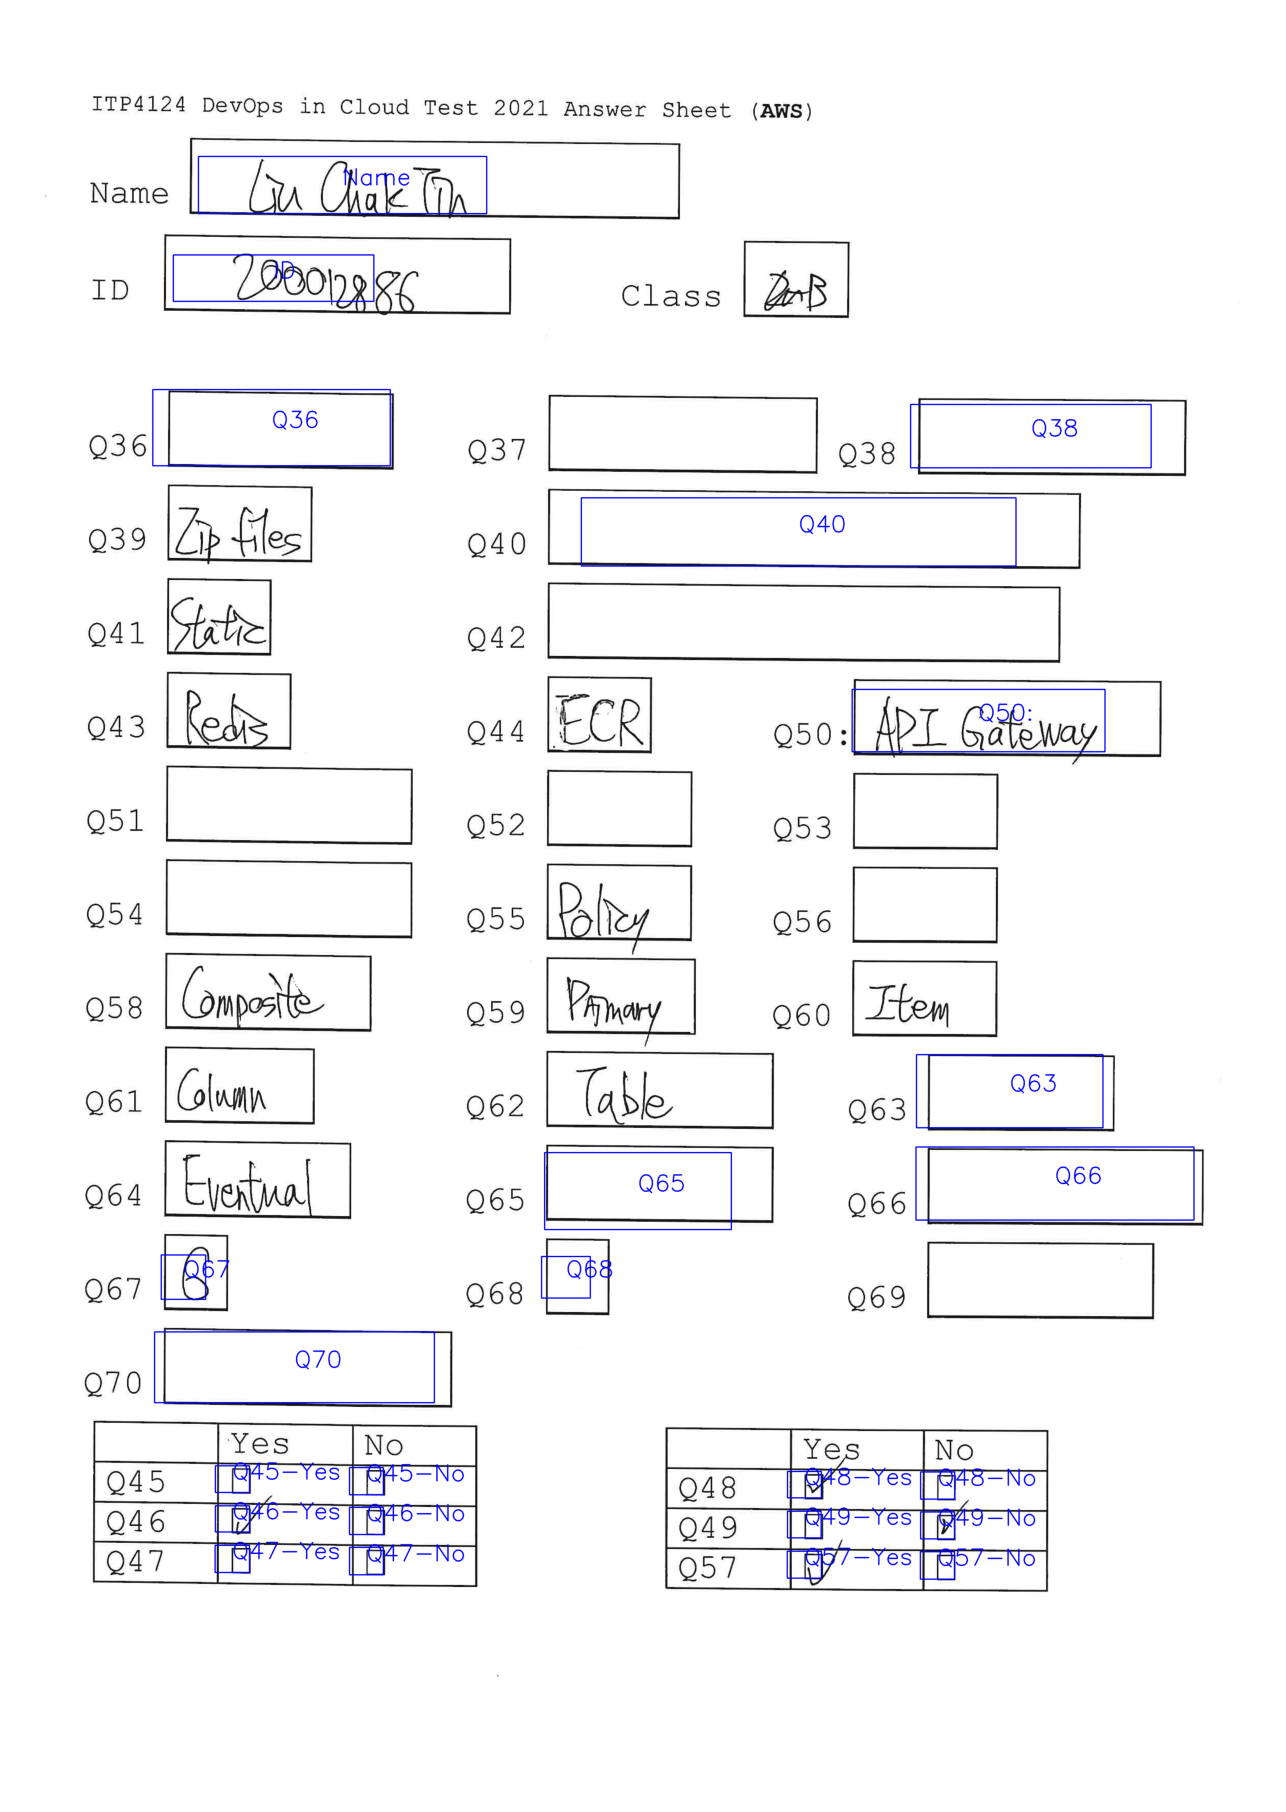

In [29]:
from IPython.display import Image

import cv2
import numpy as np
from matplotlib import pyplot as plt

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 3
color = (0, 0, 255)
thickness = 4
path = Path(os.path.join(os.getcwd(), "output", "annotation"))
path.mkdir(parents=True, exist_ok=True)

annoatedScripts = {}
for index, row in question_group.iterrows():
    if row["ignore"]:
        continue
    imagePath = df_script["DocumentAnswerImageLocal"][row["questions"]].iat[0, 0]
    group = row["group"]
    questionDocBoundingBox = list(
        map(
            lambda q: (q, estimatedBoundBoxes.loc[[q]]["boundingBox"][0]),
            row["questions"],
        )
    )
    im = Image(filename=imagePath)
    image = cv2.imread(imagePath)
    imagePath = "output/annotation/" + str(group) + ".jpg"
    for c in questionDocBoundingBox:
        question = c[0]
        boundingBox = c[1]
        start = (int(boundingBox["left"]), int(boundingBox["top"]))
        end = (
            int(boundingBox["left"] + boundingBox["width"]),
            int(boundingBox["top"] + boundingBox["height"]),
        )
        center = (
            start[0] + int(boundingBox["width"] / 2),
            start[1] + int(boundingBox["height"] / 2),
        )
        cv2.rectangle(image, start, end, color, thickness)
        cv2.putText(
            image, question, center, font, fontScale, color, thickness, cv2.LINE_AA
        )
        cv2.imwrite(imagePath, image)
    print("page " + str(group))
    plt.figure(figsize=(11.69 * 4, 8.27 * 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    annoatedScripts[group] = imagePath

In [30]:
import base64


def image_to_data_url(filename):
    ext = filename.split(".")[-1]
    prefix = f"data:image/{ext};base64,"
    with open(filename, "rb") as f:
        img = f.read()
    return prefix + base64.b64encode(img).decode("utf-8")

In [ ]:
%pip install ipykernel ipywidgets ipython_genutils numpy pandas openpyxl seaborn matplotlib scipy scikit-learn Jinja2 shapely jupyter_bbox_widget PyPDF4

# Add Answer bounding box

Please refer to https://github.com/gereleth/jupyter-bbox-widget for the shortcut and details.


In [31]:
from jupyter_bbox_widget import BBoxWidget
import ipywidgets as widgets
import os
import glob
import time


path = "output/annotation/"
files = sorted(glob.glob(path + "*.jpg"))

annotations = {}
timestr = time.strftime("%Y%m%d-%H%M%S")
annotations_path = "output/annotations-" + timestr + ".json"

w_progress = widgets.IntProgress(value=0, max=len(files), description="Progress")

page = 1

question_widget = widgets.Text(value="", placeholder="", description="Question:")

answer_widget = widgets.Text(value="", placeholder="", description="Answer:")

w_bbox = BBoxWidget(
    image=image_to_data_url(files[0]),
    classes=["question"],
)
w_bbox.attach(question_widget, name="question")
w_bbox.attach(answer_widget, name="answer")

# when Skip button is pressed we move on to the next file
def on_skip():
    w_progress.value += 1
    # open new image in the widget
    image_file = files[w_progress.value]
    w_bbox.image = image_to_data_url(image_file)
    # here we assign an empty list to bboxes but
    # we could also run a detection model on the file
    # and use its output for creating inital bboxes
    w_bbox.bboxes = []


w_bbox.on_skip(on_skip)

# when Submit button is pressed we save current annotations
# and then move on to the next file
def on_submit():
    image_file = files[w_progress.value]
    # save annotations for current image
    annotations[image_file] = w_bbox.bboxes
    with open(annotations_path, "w") as f:
        json.dump(annotations, f, indent=4)
    # move on to the next file
    on_skip()


w_bbox.on_submit(on_submit)

w_out = widgets.Output()


def on_bbox_change(change):
    w_out.clear_output(wait=True)
    with w_out:
        print(json.dumps(change["new"], indent=4))
        pageAndBoxingBoxes[w_progress.value] = change["new"]


w_bbox.observe(on_bbox_change, names=["bboxes"])

w_container = widgets.VBox(
    [
        widgets.HBox(
            [
                question_widget,
                answer_widget,
            ]
        ),
        w_progress,
        w_bbox,
        w_out,
    ]
)
w_container

If you want to reload previously bounding boxes, change the file name and uncomment the last line.

In [32]:
import json


def reload_from_file(path):
    # Opening JSON file
    f = open(path)
    # returns JSON object as
    # a dictionary
    data = json.load(f)

    data = {
        int(k.replace("output/annotation/", "").replace(".jpg", "")) - 1: v
        for k, v in data.items()
    }

    # Closing file
    f.close()
    return data


# pageAndBoxingBoxes = reload_from_file(annotations_path)
pageAndManualBoundingBoxes = reload_from_file("output/annotations.json")
pageAndManualBoundingBoxes

{0: [{'x': 474,
   'y': 1783,
   'width': 2915,
   'height': 324,
   'label': 'question',
   'question': 'Q6',
   'answer': 'Demo'},
  {'x': 454,
   'y': 2141,
   'width': 1503,
   'height': 334,
   'label': 'question',
   'question': 'Q7',
   'answer': 'Q7'},
  {'x': 423,
   'y': 2523,
   'width': 757,
   'height': 310,
   'label': 'question',
   'question': 'Q9',
   'answer': 'Q9'},
  {'x': 501,
   'y': 4695,
   'width': 2291,
   'height': 337,
   'label': 'question',
   'question': 'Q32',
   'answer': 'Q32'}],
 1: [{'x': 2073,
   'y': 1500,
   'width': 1115,
   'height': 334,
   'label': 'question',
   'question': 'Q37',
   'answer': 'Q37'},
  {'x': 600,
   'y': 1845,
   'width': 634,
   'height': 361,
   'label': 'question',
   'question': 'Q39',
   'answer': 'Q39'},
  {'x': 583,
   'y': 2216,
   'width': 512,
   'height': 345,
   'label': 'question',
   'question': 'Q41',
   'answer': 'Q41'}]}

# Generate Marking form

Check for the regeneration of question.

In [33]:
import os

questionDir = os.path.join(os.getcwd(), "output", "grading_form", "questions")
questionAndControl = {}
for path, currentDirectory, files in os.walk(questionDir):
    for file in files:
        if file == "control.json":
            question = path[len(questionDir) + 1 :]
            f = open(os.path.join(path, file))
            data = json.load(f)
            if "regenerate" in data:
                questionAndControl[question] = data
            f.close()

questionAndControl

{'Q1': {'overridedStandardAnswer': 'account',
  'regenerate': 'on',
  'fullMark': '1',
  'minimumSimilarity': '0.7',
  'granularity': '1',
  'zoom': '1',
  'boundingBoxMode': 'tractract',
  'left': '489.46929912663944',
  'top': '1088.369262709974',
  'height': '267.0980033280667',
  'width': '900.7867318981073'},
 'Q10': {'overridedStandardAnswer': 'security principal',
  'regenerate': 'on',
  'fullMark': '2',
  'minimumSimilarity': '0.8',
  'granularity': '1',
  'zoom': '1',
  'boundingBoxMode': 'manual',
  'left': '1517.6600748676456',
  'top': '2537.0342943351493',
  'height': '283.3899849342704',
  'width': '1552.219561958276'},
 'Q11': {'overridedStandardAnswer': 'assignment',
  'regenerate': 'on',
  'fullMark': '1',
  'minimumSimilarity': '0.7',
  'granularity': '1',
  'zoom': '1',
  'boundingBoxMode': 'tractractTrimedMean',
  'left': '3515.3082560077683',
  'top': '2549.1271995616044',
  'height': '264.2775975655132',
  'width': '998.6928035972148'}}

Change below settings for OCR.

If set justUserRekognition to True, it will call Amazon Rekognition even if the image does not contains any text and it will cost more on Amazon Rekognition.

If set justUserRekognition to False, it will first use EasyOCR to check the text exists, then call Amazon Rekognition to save cost but it takes much longer time for CPU runtimes.

Easy Orc supports difference languages and you can check https://github.com/JaidedAI/EasyOCR

In [34]:
justUseRekognition = True
easyocrLanguages = ["en"]
minConfidence = 70

In [35]:
import statistics
import multiprocessing
import easyocr
import tempfile
import boto3
from PIL import Image, ImageEnhance
import functools
import os

os.environ["TOKENIZERS_PARALLELISM"] = "false"


def get_rekognition_detect_text(imagePath):
    with open(imagePath, "rb") as image:
        response = rekognition.detect_text(
            Image={"Bytes": image.read()},
            Filters={"WordFilter": {"MinConfidence": minConfidence}},
        )
        textDetections = response["TextDetections"]
        texts = []
        confidences = []
        for text in textDetections:
            if text["Type"] == "LINE":
                texts.append(text["DetectedText"])
                confidences.append(text["Confidence"])
        text = " ".join(texts)
        confidence = statistics.mean(confidences) if len(confidences) > 0 else 0
        return text, confidence


def ocr_question_image(t):
    image, overrdiedBoundingBox = t[0], t[1]
    imageFile = tempfile.NamedTemporaryFile(suffix=".png").name
    with Image.open(image) as im:
        # The crop method from the Image module takes four coordinates as input.
        # The right can also be represented as (left+width)
        # and lower can be represented as (upper+height).
        (left, top, right, lower) = (
            overrdiedBoundingBox["left"],
            overrdiedBoundingBox["top"],
            overrdiedBoundingBox["left"] + overrdiedBoundingBox["width"],
            overrdiedBoundingBox["top"] + overrdiedBoundingBox["height"],
        )
        # Here the image "im" is cropped and assigned to new variable im_crop
        im_crop = im.crop((left, top, right, lower))
        imageEnhance = ImageEnhance.Sharpness(im_crop)
        # showing resultant image
        im_crop = imageEnhance.enhance(3)
        im_crop.save(imageFile, format="png")
        # display(im_crop)
        # this needs to run only once to load the model into memory

    if justUseRekognition:
        text, confidence = get_rekognition_detect_text(imageFile)
    else:
        result = reader.readtext(imageFile, detail=0)
        easyocrText = "".join(result)
        text = easyocrText
        confidence = 0
        if easyocrText != "" and canCallAWS:
            rekognitionText = get_rekognition_detect_text(imageFile)
            text, confidence = rekognitionText if rekognitionText != "" else easyocrText
    os.remove(imageFile)
    return text, confidence


def ocr_question_image2(t):
    return ocr_question_image(t[0], t[1])


def parallel_ocr_question_image(images, overrdiedBoundingBox):
    pool_obj = multiprocessing.Pool()
    overrdiedBoundingBoxes = [overrdiedBoundingBox] * len(images)
    result = pool_obj.map(ocr_question_image, zip(images, overrdiedBoundingBoxes))
    texts = [i for i, j in result]
    confidences = [j for i, j in result]
    return texts, confidences


def serial_ocr_question_image(images, overrdiedBoundingBox):
    overrdiedBoundingBoxes = [overrdiedBoundingBox] * len(images)
    result = list(map(ocr_question_image, zip(images, overrdiedBoundingBoxes)))
    texts = [i for i, j in result]
    confidences = [j for i, j in result]
    return texts, confidences

Crop Answer image and ORC again.

This following step takes time!

In [36]:
from IPython.display import display
from ipywidgets import IntProgress

numberOfManualBoundingBoxes = len(
    reduce(lambda a, b: a + b, pageAndManualBoundingBoxes.values(), [])
)
numberOfOverridedQuestions = len(questionAndControl)
numberOfOrcTask = numberOfManualBoundingBoxes + numberOfOverridedQuestions

f = IntProgress(min=0, max=numberOfOrcTask)  # instantiate the bar
display(f)  # display the bar

if justUseRekognition:
    reader = easyocr.Reader(easyocrLanguages, gpu=True)
rekognition = boto3.client("rekognition")

df_script["DocumentValueOverrided"] = df_script["DocumentValue"].copy()
df_script["DocumentConfidenceeOverrided"] = df_script["DocumentConfidence"].copy()
df_answer["DocumentValueOverrided"] = df_answer["DocumentValue"].copy()
df_script["DocumentAnswerImageLocalOverrided"] = df_script[
    "DocumentAnswerImageLocal"
].copy()
df_script["DocumentBoundingBoxImputeOverrided"] = df_script[
    "DocumentBoundingBoxImpute"
].copy()

for index, row in question_group.iterrows():
    if row["ignore"]:
        continue
    group = row["group"]
    firstQuestionOfGroup = row["questions"][0]
    images = df_script["DocumentAnswerImageLocal"][firstQuestionOfGroup].to_list()
    # print(images)

    boundingBoxes = pageAndManualBoundingBoxes[group - 1]
    for boundingBox in boundingBoxes:
        print(boundingBox)
        overrdiedBoundingBox = {
            "left": boundingBox["x"],
            "top": boundingBox["y"],
            "height": boundingBox["height"],
            "width": boundingBox["width"],
            "page": group,
        }
        texts, confidences = (
            parallel_ocr_question_image(images, overrdiedBoundingBox)
            if justUseRekognition
            else serial_ocr_question_image(images, overrdiedBoundingBox)
        )
        question = boundingBox["question"]
        df_script["DocumentValueOverrided"][question] = texts
        df_script["DocumentConfidenceeOverrided"][question] = confidences
        df_answer["DocumentValueOverrided"][question] = [boundingBox["answer"]]
        df_script["DocumentAnswerImageLocalOverrided"][question] = df_script[
            "DocumentAnswerImageLocal"
        ][firstQuestionOfGroup]
        df_script["DocumentBoundingBoxImputeOverrided"][question] = [
            overrdiedBoundingBox
        ] * len(df_script["DocumentBoundingBoxImpute"])

        f.value += 1

for question, control in questionAndControl.items():
    if control["regenerate"] == "on" and control["boundingBoxMode"] != "tractract":
        print(question, control)
        if control["boundingBoxMode"] == "manual":
            overrdiedBoundingBox = {
                "left": float(control["left"]),
                "top": float(control["top"]),
                "height": float(control["height"]),
                "width": float(control["width"]),
            }
        else:
            overrdiedBoundingBox = estimatedBoundBoxes.loc[[question]]["boundingBox"][0]
        images = df_script["DocumentAnswerImageLocal"][question].to_list()

        texts, confidences = (
            parallel_ocr_question_image(images, overrdiedBoundingBox)
            if justUseRekognition
            else serial_ocr_question_image(images, overrdiedBoundingBox)
        )

        df_script["DocumentValueOverrided"][question] = texts
        df_script["DocumentConfidenceeOverrided"][question] = confidences
    f.value += 1

IntProgress(value=0, max=10)

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


{'x': 474, 'y': 1783, 'width': 2915, 'height': 324, 'label': 'question', 'question': 'Q6', 'answer': 'Demo'}
{'x': 454, 'y': 2141, 'width': 1503, 'height': 334, 'label': 'question', 'question': 'Q7', 'answer': 'Q7'}
{'x': 423, 'y': 2523, 'width': 757, 'height': 310, 'label': 'question', 'question': 'Q9', 'answer': 'Q9'}
{'x': 501, 'y': 4695, 'width': 2291, 'height': 337, 'label': 'question', 'question': 'Q32', 'answer': 'Q32'}
{'x': 2073, 'y': 1500, 'width': 1115, 'height': 334, 'label': 'question', 'question': 'Q37', 'answer': 'Q37'}
{'x': 600, 'y': 1845, 'width': 634, 'height': 361, 'label': 'question', 'question': 'Q39', 'answer': 'Q39'}
{'x': 583, 'y': 2216, 'width': 512, 'height': 345, 'label': 'question', 'question': 'Q41', 'answer': 'Q41'}
Q10 {'overridedStandardAnswer': 'security principal', 'regenerate': 'on', 'fullMark': '2', 'minimumSimilarity': '0.8', 'granularity': '1', 'zoom': '1', 'boundingBoxMode': 'manual', 'left': '1517.6600748676456', 'top': '2537.0342943351493', 'he

Remove NaN to empty string.

In [37]:
df_script["DocumentValueOverrided"].fillna("", inplace=True)

Recalculate the answer similarity

You can change the logic and model according to https://www.sbert.net/ 

In [38]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

df_script["DocumentAnswerSimilarityOverrided"] = df_script[
    "DocumentAnswerSimilarity"
].copy()


def calculate_similarity(overridedStandardAnswer, question):
    answers = df_script["DocumentValueOverrided"][question].to_list()
    answers.insert(0, overridedStandardAnswer)
    # Compute embeddings
    embeddings = model.encode(answers, convert_to_tensor=True)
    # Compute cosine-similarities for each sentence with each other sentence
    cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
    # Find the pairs with the highest cosine similarity scores
    pairs = []
    for j in range(0, len(cosine_scores)):
        pairs.append(float(cosine_scores[0][j]))
    # Empty answer similarity must be 0.
    l = list(map(lambda x: (x[0], 0) if x[0] == "" else x, zip(answers, pairs)))
    similarties = list(list(zip(*l))[1])
    similarties.pop(0)
    return similarties


for question in map(
    lambda x: x["question"],
    reduce(lambda a, b: a + b, pageAndManualBoundingBoxes.values(), []),
):
    questionToAnswer[question] = df_answer["DocumentValueOverrided"][question][0]
    print("Calculate Similarity for " + question)
    df_script["DocumentAnswerSimilarityOverrided"][question] = calculate_similarity(
        questionToAnswer[question], question
    )

for question, control in questionAndControl.items():
    if control["regenerate"] != "on":
        continue
    print("Recalculate Similarity for " + question)
    overridedStandardAnswer = control["overridedStandardAnswer"]
    df_script["DocumentAnswerSimilarityOverrided"][question] = calculate_similarity(
        overridedStandardAnswer, question
    )

Calculate Similarity for Q6
Calculate Similarity for Q7
Calculate Similarity for Q9
Calculate Similarity for Q32
Calculate Similarity for Q37
Calculate Similarity for Q39
Calculate Similarity for Q41
Recalculate Similarity for Q1
Recalculate Similarity for Q10
Recalculate Similarity for Q11


In [39]:
def extract_table(dataframeName, question, newName):
    tempTable = df_script[dataframeName].copy()
    tempTable = tempTable[[question]]
    tempTable.reset_index(inplace=True)
    tempTable["RowNumber"] = tempTable.index
    tempTable.rename(columns={question: newName}, inplace=True)
    return tempTable


def get_question_df(question):
    answerTable = extract_table("DocumentValueOverrided", question, "Answer")
    imageTable = extract_table("DocumentAnswerImageLocalOverrided", question, "Image")
    confidenceTable = extract_table(
        "DocumentConfidenceeOverrided", question, "Confidence"
    )
    similarityTable = extract_table(
        "DocumentAnswerSimilarityOverrided", question, "Similarity"
    )
    geometryTable = extract_table(
        "DocumentBoundingBoxImputeOverrided", question, "BoundingBox"
    )

    dataTable = pd.merge(
        answerTable, imageTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, confidenceTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, similarityTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable = pd.merge(
        dataTable, geometryTable, on="RowNumber", suffixes=("", "_remove")
    )
    dataTable.drop(
        [i for i in dataTable.columns if "_remove" in i], axis=1, inplace=True
    )

    dataTable["Similarity"] = dataTable["Similarity"].fillna(0)
    dataTable["Answer"] = dataTable["Answer"].fillna("")
    dataTable["Image"] = dataTable["Image"].str.replace("output/grading_form/", "")

    dataTable = dataTable.sort_values(by=["Similarity"], ascending=False)
    return dataTable


def save_template_output(output, question, filename):
    path = Path(
        os.path.join(os.getcwd(), "output", "grading_form", "questions", question)
    )
    path.mkdir(parents=True, exist_ok=True)
    path = Path(
        os.path.join(
            os.getcwd(), "output", "grading_form", "questions", question, filename
        )
    )
    text_file = open(path, "w")
    text_file.write(output)
    text_file.close()

In [40]:
from distutils.dir_util import copy_tree

from_directory = os.path.join(os.getcwd(), "templates", "javascript")
to_directory = os.path.join(os.getcwd(), "output", "grading_form", "javascript")
copy_tree(from_directory, to_directory)

['/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/javascript/.ipynb_checkpoints/common-checkpoint.js',
 '/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/javascript/common.js']

In [41]:
from jinja2 import Template
from jinja2 import Environment, FileSystemLoader

file_loader = FileSystemLoader("templates")
env = Environment(loader=file_loader)
template = env.get_template("index.html")

questions = df_script["DocumentAnswerSimilarityOverrided"].columns.to_list()


textAnswer = []
for question in questions:
    optionsDf = estimatedBoundBoxesOptions[
        estimatedBoundBoxesOptions.index.str.fullmatch(question)
    ]
    if optionsDf.empty:  # skip choice questions
        textAnswer.append(question)
optionAnswer = estimatedOptions.index.to_list()

questionOfMarks = textAnswer + optionAnswer

output = template.render(
    studentsScriptFileName=studentsScriptFileName,
    textAnswer=textAnswer,
    optionAnswer=optionAnswer,
)
# open text file
path = Path(os.path.join(os.getcwd(), "output", "grading_form", "questions"))
path.mkdir(parents=True, exist_ok=True)
path = Path(os.path.join(os.getcwd(), "output", "grading_form", "index.html"))
text_file = open(path, "w")
text_file.write(output)
text_file.close()

Generate grading form for text answer questions.

In [42]:
questions = df_script["DocumentAnswerSimilarityOverrided"].columns.to_list()

for question in questions:

    optionsDf = estimatedBoundBoxesOptions[
        estimatedBoundBoxesOptions.index.str.fullmatch(question)
    ]
    if not optionsDf.empty:  # skip choice questions
        continue
    dataTable = get_question_df(question)

    standardAnswer = None
    estimatedBoundingBox = None
    if question in df_answer["DocumentValueOverrided"].columns:
        standardAnswer = questionToAnswer[question]
    if question in df_script["DocumentBoundingBox"].columns:
        estimatedBoundingBox = estimatedBoundBoxes.loc[[question]]["boundingBox"][0]

    if question == "ID" or question == "Name":
        template = env.get_template("questions/index-answer.html")
    else:
        template = env.get_template("questions/index.html")
    output = template.render(
        studentsScriptFileName=studentsScriptFileName,
        question=question,
        standardAnswer=standardAnswer,
        estimatedBoundingBox=estimatedBoundingBox,
        dataTable=dataTable,
    )
    save_template_output(output, question, "index.html")

    template = env.get_template("questions/question.js")
    output = template.render(
        dataTable=dataTable,
        estimatedBoundingBox=estimatedBoundingBox,
    )
    save_template_output(output, question, "question.js")

    template = env.get_template("questions/style.css")
    output = template.render(
        dataTable=dataTable,
    )
    save_template_output(output, question, "style.css")

Generate grading form for choices style questions.

In [43]:
for index, row in estimatedOptions.iterrows():
    question = index
    choices = row["choices"]
    estimatedBoundingBox = row["boundingBox"]
    answers = row["answers"]
    answersMask = list(
        map(lambda c: 1 if c.replace(question + "-", "") in answers else 0, choices)
    )
    choicesDf = list(map(lambda o: (o, get_question_df(o)), choices))

    rowNumber = choicesDf[0][1]["RowNumber"]
    images = choicesDf[0][1]["Image"]

    df = pd.DataFrame(
        list(zip(rowNumber, images)), columns=["RowNumber", "Image"], index=rowNumber
    )

    choiceDict = {}
    for index, item in enumerate(choicesDf):
        q, qdf = item
        # Remove Image for option as it is a common column and convert to dict
        choiceDict[q] = qdf.drop(["Image"], axis=1).to_dict("index")

    def get_confidence(index):
        return min(map(lambda c: choiceDict[c][index]["Confidence"], choices))

    def get_answer(index):
        return ",".join(
            map(
                lambda c: "1" if choiceDict[c][index]["Answer"] == "X" else "0", choices
            )
        )

    df["choices"] = pd.Series([choices for x in range(len(df.index))])
    df["BoundingBox"] = pd.Series([estimatedBoundingBox for x in range(len(df.index))])
    df["answers"] = pd.Series([answers for x in range(len(df.index))])
    df["Answer"] = pd.Series([get_answer(x) for x in range(len(df.index))])
    df["Confidence"] = pd.Series([get_confidence(x) for x in range(len(df.index))])

    template = env.get_template("questions/index-choices.html")
    output = template.render(
        studentsScriptFileName=studentsScriptFileName,
        question=question,
        standardAnswer=" ".join(answers),
        answersMask=answersMask,
        estimatedBoundingBox=estimatedBoundingBox,
        dataTable=df,
        choiceDict=choiceDict,
    )

    save_template_output(output, question, "index.html")

    template = env.get_template("questions/question.js")
    output = template.render(
        dataTable=dataTable,
        estimatedBoundingBox=estimatedBoundingBox,
    )
    save_template_output(output, question, "question.js")

    template = env.get_template("questions/style.css")
    output = template.render(
        dataTable=dataTable,
    )
    save_template_output(output, question, "style.css")

# Start Python HTTPServer

Copy your Juptyer notebook url i.e. 

https://xxxxx.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/lab/tree/sagemaker-studiolab-notebooks/marking_form_builder.ipynb

Paste into a new broswer tab and change it to: 

https://xxxxx.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/proxy/8000/

When you finished your grading tasks, you need to stop the webserver with Interrupt Kernel.

The webserver log is in output/server.log.

If you are in development and don't want the notebook being blocked by running webserver, you can open a terminal and run the below 2 commands.

cd sagemaker-studiolab-notebooks/

python server.py 8000

In [44]:
# !python server.py 8000

# Backup grading result

In [45]:
import shutil

shutil.make_archive(
    os.path.join(os.getcwd(), "output", "grading_form", "questions"),
    "zip",
    os.path.join(os.getcwd(), "output", "grading_form", "questions"),
)
shutil.make_archive(
    os.path.join(os.getcwd(), "output"),
    "zip",
    os.path.join(os.getcwd(), "output"),
)

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output.zip'

In [46]:
display("Dowload question html files.")
display(os.path.join(os.getcwd(), "output", "grading_form", "questions.zip"))
display("Dowload grading form files with everything.")
display(os.path.join(os.getcwd(), "output.zip"))

'Dowload question html files.'

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output/grading_form/questions.zip'

'Dowload grading form files with everything.'

'/home/studio-lab-user/sagemaker-studiolab-notebooks/output.zip'

# Generate Marksheet

You must visit the ID and Name pages to verify the values before generate the marksheet.

In [47]:
import os

questionDir = os.path.join(os.getcwd(), "output", "grading_form", "questions")
questionAndMarks = {}
for path, currentDirectory, files in os.walk(questionDir):
    for file in files:
        if file == "mark.json":
            question = path[len(questionDir) + 1 :]
            f = open(os.path.join(path, file))
            data = json.load(f)
            marks = {}
            for i in data:
                marks[i["id"]] = (
                    i["overridedMark"] if i["overridedMark"] != "" else i["mark"]
                )
            questionAndMarks[question] = marks
            f.close()
marksDf = pd.DataFrame(questionAndMarks)
marksDf = marksDf[
    ["ID", "Name"]
    + [col for col in sorted(marksDf.columns) if col != "ID" and col != "Name"]
]

marksDf["Marks"] = (
    marksDf.loc[:, ~marksDf.columns.isin(["ID", "Name", "QRCODE"])]
    .apply(pd.to_numeric)
    .sum(axis=1)
)
print(marksDf)

            ID              Name Q1 Q10 Q11 Q12 Q14 Q15 Q18 Q2 Q23 Q25  Marks
0    200012886       Gu Chak TTh  0   0   0   0   1   1   1  0   0   0      3
29   200276566      Ng Wing chur  0   0   0   0   1   1   1  0   0   0      3
31   200006867     Tsoi Kai Miny  0   0   0   0   1   1   1  0   0   0      3
32   200035120    Tsang Yuk Knen  0   0   0   0   1   1   1  0   0   0      3
33   200275822     Leung Ts2 Hin  0   0   0   0   1   1   1  0   0   1      4
34   200172741      Chan Wailtin  0   0   0   0   1   1   1  0   0   0      3
35  2000 82391      lan 1s2 Hons  0   0   0   0   1   1   1  0   0   0      3
36   200086758       Li Lok Heng  0   0   0   0   1   1   1  0   0   0      3
37   200241763      Tam Hin Chan  0   0   0   0   1   1   1  0   0   0      3
38   200177527      Chow Kin Man  0   0   0   0   1   1   1  0   0   0      3
39     2002363       ling Pc Chn  0   0   0   0   1   1   1  0   0   0      3
40   200270390      Man Kai Hons  0   0   0   0   1   1   1  0  

The questionWithoutMarks should be an empty list and the list items are the question without mark.

In [48]:
questionWithoutMarks = list(set(questionOfMarks) - set(marksDf.columns))
questionWithoutMarks

['Q39',
 'Q35',
 'Q36',
 'Q5',
 'Q34',
 'Q38',
 'Q66',
 'Q9',
 'Q47',
 'Q8',
 'Q63',
 'Q3',
 'Q41',
 'Q27',
 'Q22',
 'Q16',
 'Q26',
 'Q70',
 'Q45',
 'Q57',
 'Q67',
 'Q33',
 'Q40',
 'Q20',
 'Q65',
 'Q6',
 'Q4',
 'Q50:',
 'Q46',
 'Q19',
 'Q30',
 'Q21',
 'Q37',
 'Q48',
 'Q49',
 'Q24',
 'Q7',
 'Q13',
 'Q32',
 'Q17',
 'Q28',
 'Q31',
 'Q68']

# Create Marked Scripts

In [49]:
import shutil
import os

src_dir = "output/grading_form/images"
dest_dir = "output/marks/images"
if os.path.exists(dest_dir):
    shutil.rmtree(dest_dir)
shutil.copytree(src_dir, dest_dir)

'output/marks/images'

In [50]:
questionToGroup = {}
for qg in question_group[question_group["ignore"] == False].iterrows():
    group = qg[1]["group"]
    questionsInGroup = qg[1]["questions"]
    for q in questionsInGroup:
        if q in estimatedBoundBoxesOptions.index:
            questionToGroup[estimatedBoundBoxesOptions.loc[[q]]["question"][0]] = group
        else:
            questionToGroup[q] = group

markers = []
for student in marksDf.iterrows():
    rowNumber = student[0]
    # print(student[1])
    questionToImage = (
        df_script["DocumentAnswerImageLocalOverrided"].iloc[[rowNumber]].to_dict()
    )
    for question in marksDf.columns:
        if question == "Name":
            continue
        if question == "Marks":
            value = "Total Marks: " + str(marksDf["Marks"].iloc[[rowNumber]].values[0])
            question = "Name"
        else:
            value = marksDf[question].iloc[[rowNumber]].values[0]
        boundingBox = (
            estimatedBoundBoxes.loc[[question]]["boundingBox"][0]
            if question in estimatedBoundBoxes.index
            else estimatedBoundBoxesOptions[
                estimatedBoundBoxesOptions["question"] == question
            ]["boundingBox"][0]
        )
        group = questionToGroup[question]
        # print(question,questionToBoundingBox,group)
        questionToImage = (
            df_script["DocumentAnswerImageLocalOverrided"].iloc[[rowNumber]].to_dict()
        )
        # print(questionToImage)
        if question in questionToImage:
            image = questionToImage[question]
        else:
            choiceQuestion = (
                estimatedBoundBoxesOptions[
                    estimatedBoundBoxesOptions["question"] == question
                ]
                .head(1)
                .index.map(str)[0]
            )
            image = questionToImage[choiceQuestion]

        marker = [
            {
                "rowNumber": k,
                "image": v.replace(
                    "output/grading_form/images",
                    "output/marks/images",
                ),
                "question": question,
                "group": group,
                "boundingBox": boundingBox,
                "value": value,
            }
            for k, v in image.items()
        ][0]
        markers.append(marker)

In [51]:
from collections import defaultdict
from IPython.display import display
from ipywidgets import IntProgress
import cv2
import numpy as np
from matplotlib import pyplot as plt

font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 4
color = (0, 0, 255)
thickness = 4

groups = defaultdict(list)
for marker in markers:
    groups[marker["image"]].append(marker)

f = IntProgress(min=0, max=len(groups))  # instantiate the bar
display(f)  # display the bar

for imagePath, pageMarkers in groups.items():
    image = cv2.imread(imagePath)
    for pageMarker in pageMarkers:
        boundingBox = pageMarker["boundingBox"]
        end = (
            int(boundingBox["left"] + boundingBox["width"]),
            int(boundingBox["top"] + boundingBox["height"]),
        )
        cv2.putText(
            image,
            str(pageMarker["value"]),
            end,
            font,
            fontScale,
            color,
            thickness,
            cv2.LINE_AA,
        )
    cv2.imwrite(imagePath, image)
    f.value += 1

IntProgress(value=0, max=114)

In [52]:
from IPython.display import display
from ipywidgets import IntProgress
from collections import defaultdict
from PIL import Image

groups = defaultdict(list)
for marker in markers:
    groups[marker["rowNumber"]].append(marker)


def dedupicate(seen, x):
    if x["image"] not in seen:
        seen.add(x["image"])
        return True
    return False


for rowNumber in groups.keys():
    seen = set()
    groups[rowNumber] = sorted(
        list(
            filter(
                lambda f: dedupicate(seen, f),
                map(
                    lambda x: {"group": x["group"], "image": x["image"]},
                    groups[rowNumber],
                ),
            )
        ),
        key=lambda x: x["group"],
    )

f = IntProgress(min=0, max=len(groups))  # instantiate the bar
display(f)  # display the bar

for rowNumber in groups.keys():
    images = [Image.open(f) for f in map(lambda x: x["image"], groups[rowNumber])]
    pdf_path = "output/marks/" + str(rowNumber) + ".pdf"
    images[0].save(
        pdf_path, "PDF", resolution=100.0, save_all=True, append_images=images[1:]
    )
    f.value += 1

IntProgress(value=0, max=57)

# Generate Script Sample

4 set Samples:
1. 3 Good, 3 Average, and 3 Weak.
2. 5 Good, 5 Average, and 5 Weak.
3. 3 Good, 3 Average, and 3 Weak above the passmark.
4. 5 Good, 5 Average, and 5 Weak above the passmark.

In [53]:
passingMark = 2

In [54]:
from os import pardir
from os.path import abspath, dirname, join
from sys import argv, path
from PyPDF4 import PdfFileMerger, PdfFileReader

sampling = marksDf.sort_values(by=["Marks"], ascending=False)["Marks"]

goodPage = PdfFileReader("templates/pdf/Good.pdf")
averagePage = PdfFileReader("templates/pdf/Average.pdf")
weakPage = PdfFileReader("templates/pdf/Weak.pdf")

sampleDir = "output/samples"
os.makedirs(sampleDir, exist_ok=True)


def get_scripts_psf(df):
    return list(map(lambda rowNumber: "output/marks/" + rowNumber + ".pdf", df.index))


def take_sample(n, sampling, suffix=""):
    if len(sampling) < 3 * n:
        n = int(len(sampling) / 3)
    good = sampling.head(n)
    weak = sampling.tail(n)
    median = int(len(sampling) / 2)
    take = int(n / 2)
    average = sampling.iloc[middle - take : middle + take]

    merger = PdfFileMerger()
    merger.append(goodPage)
    for pdf in get_scripts_psf(good):
        merger.append(PdfFileReader(pdf))
    merger.append(averagePage)
    for pdf in get_scripts_psf(average):
        merger.append(PdfFileReader(pdf))
    merger.append(weakPage)
    for pdf in get_scripts_psf(weak):
        merger.append(PdfFileReader(pdf))
    fileName = "output/samples/sampleOf" + str(n) + suffix + ".pdf"
    merger.write(open(fileName, "wb"))
    print("Output successfully written to" + fileName)
    merger.close()


take_sample(3, sampling)
take_sample(5, sampling)

sampling = sampling.where(lambda x: x > passingMark)
take_sample(3, sampling, "_only_pass")
take_sample(5, sampling, "_only_pass")

merger = PdfFileMerger()
for pdf in get_scripts_psf(marksDf.sort_values(by=["ID"], ascending=False)["Marks"]):
    merger.append(PdfFileReader(pdf))
fileName = "output/samples/All.pdf"
merger.write(open(fileName, "wb"))

NameError: name 'middle' is not defined

Please refer to the below post for the setup of SMTP with gmail.
https://hotter.io/docs/email-accounts/secure-app-gmail/

In [ ]:
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

email = config["default"]["email"]
password = config["default"]["password"]
smtp_server = config["default"]["smtp_server"]
smtp_port = config["default"]["smtp_port"]


mail_content = """Hello,
This is a test mail.
In this mail we are sending some attachments.
The mail is sent using Python SMTP library.
Thank You
"""
# The mail addresses and password
sender_address = email
sender_pass = password
receiver_address = "cywong@vtc.edu.hk"
# Setup the MIME
message = MIMEMultipart()
message["From"] = sender_address
message["To"] = receiver_address
message["Subject"] = "A test mail sent by Python. It has an attachment."
# The subject line
# The body and the attachments for the mail
message.attach(MIMEText(mail_content, "plain"))
attach_file_name = "output/marks/1.pdf"
attach_file = open(attach_file_name, "rb")  # Open the file as binary mode
payload = MIMEBase("application", "octate-stream")
payload.set_payload((attach_file).read())
encoders.encode_base64(payload)  # encode the attachment
# add payload header with filename
payload.add_header("Content-Decomposition", "attachment", filename=attach_file_name)
message.attach(payload)
# Create SMTP session for sending the mail
session = smtplib.SMTP(
    smtp_server, int(smtp_port), source_address=("localhost", 0)
)  # use gmail with port
session.starttls()  # enable security
session.ehlo()
session.login(sender_address, sender_pass)  # login with mail_id and password
text = message.as_string()
session.sendmail(sender_address, receiver_address, text)
session.quit()
print("Mail Sent")